In [513]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import os
import seaborn as sns
import matplotlib.ticker as mticker
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Investigating Stock Price Influences: The Impact of Tweets, Insider Trading, and Earnings

## Abstract

This project explores the correlation between different indicators and their impact on the stock prices. The focus is particularly on earnings statements, insider trading activity and tweet sentiment analysis. To conduct the research, relevant datasets were selected, tidied and compared using a wide range of statistical and analytical techniques, in order to asses their influence on stock market behaviour. The research not only analyses the well-known correlation between financial indicators and stock prices, but also investigates how tweets sentiment can trigger movements in the market. The analysis managed to reveal the significant relationship between the studied data and the expected market reactions.

## 1. Introduction

The stock market is a complex system influenced by many factors. All of the people, that trade long or short term stocks, always seek ways to dynamics, that drive stock prices. The traditional financial indicators like earnings, financial statements and insider trading activities have long been linked with influincing the market. The rise of social media and the interconnected world, we live in, introduces a new dimension to market analysis. The social network websites like twitter and reddit are considered to potentially trigger a market movement. We have observed such cases in the last couple of years, for example with Gamestop and Dogecoin, but does it happen more often and is it as reliable as the traditional indicators?

This project aims to investigate how various factors, that influence stock prices. By leveraging multiple datasets, comprehensive analysis will be conducted, in order to identify the extent to which these factors impact stock market behavior and what factors seem to be more useful than others.

- **What is the stock market?**

The stock market as a whole is an exchange mechanism that helps investors buy and sell shares in publicly traded companies. Though you can visit the New York Stock Exchange (NYSE) and offices of the NASDAQ, these are just components in a broader marketplace. Trades are conducted mostly through electronic means between participants who are remote from each other. The mechanism is an excellent means for businesses to raise capital from investors. Additionally, analysts closely examine its traded prices for signals of economic strength or weakness. [1]

The price of a stock changes based on the demand for shares from new investors who want to buy, or the supply of shares from existing investors who want to sell. Investors decide to buy or sell based on the company’s performance, economic conditions, the current price of the shares, and other factors. Not every investor makes decisions based on the same criteria, and what might not seem rational to one investor, will seem perfectly acceptable to another. This dynamic keeps shares trading hands and makes future prices difficult to predict. People purchase stocks for a lot of reasons. Some hold onto shares, looking for income from dividends. Others might think a stock will rise, so they snap it up, trying to buy low and sell high. Still, others might be interested in having a say in how particular companies are run. That’s because you can vote at shareholder meetings based on the number of shares you own. [1]

There are also many different types of assets, that can be traded in the stock market like stocks, indexes, forex and from a couple of years ago even cryptocurrencies. All of them have different indicators, that make them move up or down.

- Stock

Stocks represent ownership of shares in a company. Basically when you buy a stock you purchase a very small piece of that company and become a shareholder. The price is mostly influenced by the earnings reports, economic data and market trends, as well as other indicators like dividend yields and different financial ratios. It might also change based on major or even minor changes in the industry, that it is in.

- Index

Indexes are measurement of the performace of a group of stocks or other securities, representing a particular market or sector. The most popular ones - VOO500 and S&P 500 comprise of the 500 best companies in the US. That way you not only invest in one company, but in 500 and even if one does bad, there are 499 to do better. They are often more stable and there aren't significant market movements.

- Cryptocurrency

Cryptocurrencies are virtual currencies, that use cryptography for security. The special thing about them is that, they are decentralized and operate on blockchain technology. They are much more volatile that all other securities, because there isn't a big company or corporation behind them. Basically people buy and sell them and that what drives the price up or down. Because of that, people can be easily influenced by the news and trends, which leads to a rapid response in the price.

- Forex

Forex is the global marketplace for trading national currencies against one another. For example you can buy USD with EUR, hoping that the dollar will go up and then sell back again to euro. They are influeced by macroeconomic factors such as interest rates, inflation, employment data and geopolitical events. When the war in Ukraine started, the Russian ruble dropped over 30% in a week, because of this uncertainty, so there can be major moves, but not so likely, unless a big crisis is on the verge or some global event is occuring.

In this project, the main focus is on analyzing stocks. The conclusions might also affect the other securities being traded, since they are very much simillar. 

- **What factors make the stock move?**

Stock prices are determined in the marketplace, where seller supply meets buyer demand. There should be always a reason, when the buyers buy and sellers sell. Unfortunately, there is no clean equation that tells us exactly how the price of a stock will behave. That said, we do know a few things about the forces that move a stock up or down. [2]

In an efficient market, stock prices would be determined primarily by fundamentals, like the financial statements, earnings and technical analysis.

An owner of common stock has a claim on earnings, and earnings per share (EPS) is the owner's return on their investment. When you buy a stock, you are purchasing a proportional share of an entire future stream of earnings. That's the reason for the valuation multiple: It is the price you are willing to pay for the future stream of earnings.

Part of these earnings may be distributed as dividends, while the remainder will be retained by the company (on your behalf) for reinvestment. We can think of the future earnings stream as a function of both the current level of earnings and the expected growth in this earnings base.

EPS is one of the most common measurement, there are also many other financials, which might be just as important, depending on the stock. The cashflow of the company, book ratio (the assets, the company owns compared with the price), dividends and many more are used by analysts throughout the world as indicators of when to buy a stock.

Apart from all of the financial indicators, there are technical factors, that affect the stock prices such as inflation, current economic strength, geopolitical situation, hedge fund ownership in a stock and trends. All of those may or may not affect a certain stock, based on how dependant it is on them.

Also other more recent factors, that affect the stock market are the people, that trade. 10 years ago, most of the trades were made by big hedge funds, which managed the people's money, but since then a lot has changed and nowadays many normal people without any knowledge get on the trading plaforms and trade. They may not be familliar with all of the above mentioned points - they just hear on the news, a company is doing good, releasing new revolutionazing products and decide to buy. The decisions of those people can be highly influenced by social media and news. For example if they hear, that a company they own is having a lawsuit against it, the normal person might not even dig deeper on why and just sell the stock as a precaution. For such people the social medias can play crucial role in the stock market prices going up or down.

- **Technical Terms**

This project includes a lot of technical terms, so let's explain the most common ones.

- Dividend

A dividend is a payment made by a corporation to its shareholders, usually in the form of cash or additional shares. Dividends are typically distributed from the company's profits or reserves and are a way for companies to share their earnings with investors.

- Stock split

A stock split occurs when a company increases the number of its outstanding shares by issuing more shares to its existing shareholders. This action reduces the stock's price while maintaining the total value of shareholders' holdings. For example, in a 2-for-1 split, each shareholder receives an additional share for each share they already own, and the stock price is halved.

- EPS

We already mentions earnings per share quite a bit. It is a financial metric that indicates the portion of a company's profit allocated to each outstanding share of common stock. It is calculated by dividing the net income of a company by its total number of outstanding shares. EPS is often used by investors to assess a company’s profitability.

- Estimated EPS

Estimated EPS is the profit per share expected by analysts for a given period, typically a quarter or a year. These estimates are based on various factors, including historical performance, market conditions, and the company's financial outlook. Investors compare estimated EPS with actual EPS to gauge a company's performance.

- Insider Trading

Insider trading involves the buying or selling of a company’s stock by individuals who have access to non-public, material information about the company. This practice can be legal if the trading is done with proper disclosures, but illegal insider trading involves the use of confidential information to gain an unfair market advantage.

- Market Sentiment

Market sentiment refers to the overall attitude of investors toward a particular security or financial market. It is the collective emotion or tone of the market, which can be bullish (optimistic) or bearish (pessimistic).

- Volatility

Volatility refers to the degree of variation in the price of a financial instrument over time. Higher volatility indicates larger price swings, while lower volatility suggests more stable prices. It is often used as a measure of risk in financial markets.

- Option Exercise

When an option holder exercises their option, they are choosing to buy (if it's a call option) or sell (if it's a put option) the stock at the strike price. This is typically done when the option is "in the money," meaning the market price of the stock is favorable compared to the strike price.

## 2. Data Collection and Preparation

- **Overview**

To conduct a comprehensive analysis of the factors influencing stock prices, we have utilized a diverse set of datasets from Kaggle. These datasets encompass a range of information, including stock market data, insider trading activities, financial indicators, social media sentiment, and earnings data. Below is an overview of each dataset:

   1. **Stock Market Data**:
      
      - **Source**: [Price Volume Data for All U.S. Stocks & ETFs](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)
   
   This dataset includes price and volume data for all U.S. stocks and ETFs, offering a comprehensive view of market movements over time. It provides essential information such as opening and closing prices, highest and lowest prices, and trading volumes.

   The dataset is in multiple csv files, located in "stocks_data" folder. Lets begin by reading all the csv's and combining them to a dataframe.

   Each csv contains information about the date, stock prices throughout it, volume, paid dividends and stock splits. That is why, when adding to to a big dataframe, we need to extract the stock ticker, so we can differentiate them.

In [391]:
def load_csv_data(folder_path):
    """
    Load and concatenate stock data from multiple CSV files in a given folder.
    
    Parameters:
    folder_path (str): The path to the folder containing the CSV files.
    
    Returns:
    pd.DataFrame: A concatenated DataFrame containing data from all CSV files, with an additional 'ticker' column.
    """
    dataframes = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            temp_df = pd.read_csv(file_path)
            
            ticker = file_name.replace(".csv", "")
            
            temp_df['ticker'] = ticker
            
            dataframes.append(temp_df)

    combined_data = pd.concat(dataframes, ignore_index=True)

    return combined_data

stock_data = load_csv_data('stocks_data')
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,1999-11-18,27.896016,30.654965,24.523970,26.976368,62546380.0,0.0,0.0,A
1,1999-11-19,26.324950,26.363270,24.409017,24.753885,15234146.0,0.0,0.0,A
2,1999-11-22,25.328663,26.976368,24.562289,26.976368,6577870.0,0.0,0.0,A
3,1999-11-23,26.056724,26.746461,24.523975,24.523975,5975611.0,0.0,0.0,A
4,1999-11-24,24.600619,25.711862,24.523981,25.175400,4843231.0,0.0,0.0,A


In [392]:
stock_data.dtypes

Date             object
Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
Dividends       float64
Stock Splits    float64
ticker           object
dtype: object

Let's do some cleaning of the dataset. The data types seem to be correct apart from the date column. The columns need to be changed to python-like names.

Since we will be investigating a lot of datasets and much bigger ones, lets create a script for it.

In [393]:
def convert_to_snake_case(df):
    """
    Converts all column names in a DataFrame to snake_case.
    
    Parameters:
    df: The DataFrame whose columns need to be renamed.
    
    Returns:
    pd.DataFrame: A DataFrame with column names in snake_case.
    """
    def snake_case(s):
        snake_case = s
        snake_case = re.sub(r' ', '_', snake_case)
        return snake_case.lower()
    
    # Apply snake_case to all column names
    return [snake_case(col) for col in df.columns]

In [394]:
stock_data_tidy = stock_data
stock_data_tidy.columns = convert_to_snake_case(stock_data)

In [395]:
stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)

In [396]:
stock_data_tidy.dtypes

date            datetime64[ns]
open                   float64
high                   float64
low                    float64
close                  float64
volume                 float64
dividends              float64
stock_splits           float64
ticker                  object
dtype: object

In [397]:
len(stock_data_tidy.groupby(stock_data_tidy.ticker))

503

In [398]:
stock_data_tidy.date.min(), stock_data_tidy.date.max()

(Timestamp('1962-01-02 00:00:00'), Timestamp('2022-07-12 00:00:00'))

There is information about 503 different stocks in the dataset with their prices in the timeframe 1962 - 2022. Although not all stocks have this timeframe.

Let's make dividends and stock splits to NaN, where they are 0, since 0 is not a correct value for it.

In [399]:
stock_data_tidy.dividends = stock_data_tidy.dividends.where(stock_data_tidy.dividends != 0, np.nan)
stock_data_tidy.stock_splits = stock_data_tidy.stock_splits.where(stock_data_tidy.stock_splits != 0, np.nan)

In [400]:
len(stock_data_tidy[stock_data_tidy.dividends.notna()]), len(stock_data_tidy[stock_data_tidy.stock_splits.notna()])

(45165, 1566)

In [510]:
def plot_top_traded_stocks_by_volume(total_volume, title, top_n=20):
    """
    Plots the top N most traded stocks by total volume.

    Parameters:
    - total_volume (DataFrame): A DataFrame containing 'ticker' and 'volume' columns.
    - title (str): The title of the plot.
    - top_n (int): The number of top stocks to display. Default is 20.

    Returns:
    - None: Displays a bar chart of the top N traded stocks by volume.
    """
    # Sort by total volume to find the top traded stocks
    top_volume_stocks = total_volume.sort_values(by='volume', ascending=False).head(top_n)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(top_volume_stocks['ticker'], top_volume_stocks['volume'])
    plt.title(title)
    plt.xlabel('Ticker')
    plt.ylabel('Total Volume Traded (in billions)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    
    # Format y-axis to show billions
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 10**9:.0f}'))

    plt.show()

There are a total of 45 165 dividend pay outs and 1566 stock spits in the dataset.

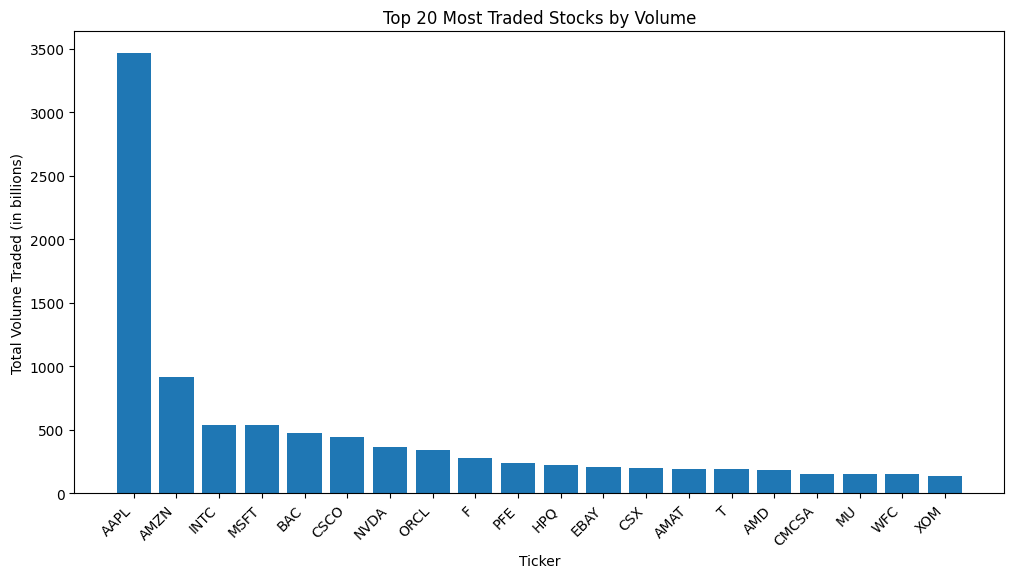

In [514]:
stocks_volume = stock_data_tidy.groupby('ticker')['volume'].sum().reset_index()

plot_top_traded_stocks_by_volume(stocks_volume, 'Top 20 Most Traded Stocks by Volume', 20)

We can see, that AAPL (Apple) is the most traded stock of all time, surpasing all the other stocks by a big margin. Let's maybe do a check in the last 5 years.

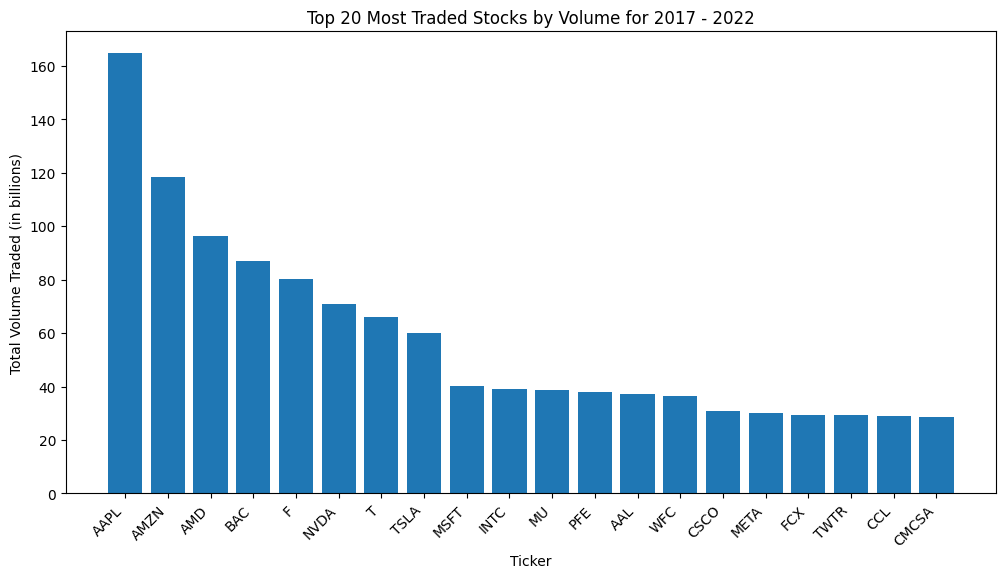

In [515]:
stocks_volume = stock_data_tidy[stock_data_tidy.date.dt.year >= 2017].groupby('ticker')['volume'].sum().reset_index()

plot_top_traded_stocks_by_volume(stocks_volume, 'Top 20 Most Traded Stocks by Volume for 2017 - 2022', 20)

We can see, that AAPL still remains the most traded stock, but not with that big of a lead.

   2. **Insider Trading Data**:
      
      - **Source**: [Insider Trading S&P 500 Inside Info](https://www.kaggle.com/datasets/ilyaryabov/insider-trading-sp500-inside-info)

This dataset shows insider trading activities, including trades made by executives and other insiders within S&P 500 companies. Information includes the type of trade (buy/sell), the number of shares traded, and the position of the insider within the company.

Here the data is again in files, separated for each company. Let's read it.

In [402]:
insider_trading = load_csv_data('insider_trading')

insider_trading.head()

,Insider Trading,Relationship,Date,Transaction,Cost,Shares,Value ($),Shares Total,SEC Form 4,ticker
0,Ancher-Jensen Henrik,Sr Vice President,2022-12-14,Sale,155.78,"29,500","4,595,510","70,793",Dec 15 12:22 PM,A
1,Grau Dominique,Senior Vice President,2022-12-13,Sale,159.20,"4,000","636,800","92,379",Dec 15 12:20 PM,A
2,MCDONNELL PADRAIG,Sr. Vice President,2022-12-13,Sale,160.00,672,"107,520","15,529",Dec 15 12:21 PM,A
3,KOH BOON HWEE,Director,2022-12-06,Sale,152.21,"13,000","1,978,692","57,752",Dec 08 11:31 AM,A
4,Thaysen Jacob,Sr. Vice President,2022-12-01,Sale,155.65,"3,235","503,528","84,464",Dec 02 01:45 PM,A


In [403]:
insider_trading.dtypes

Insider Trading     object
Relationship        object
Date                object
Transaction         object
Cost               float64
Shares              object
Value ($)           object
Shares Total        object
SEC Form 4          object
ticker              object
dtype: object

As we can see the data types here are almost all in the wrong data type and also the names are not in snake case. Let's fix it.

In [404]:
insider_trading_tidy = insider_trading

insider_trading_tidy.columns = convert_to_snake_case(insider_trading_tidy)

In [405]:
insider_trading_tidy = insider_trading_tidy.rename(columns={'value_($)': 'value', 'sec_form_4': 'sec_form', 'insider_trading': 'name'})

In [406]:
insider_trading_tidy.head()

,name,relationship,date,transaction,cost,shares,value,shares_total,sec_form,ticker
0,Ancher-Jensen Henrik,Sr Vice President,2022-12-14,Sale,155.78,"29,500","4,595,510","70,793",Dec 15 12:22 PM,A
1,Grau Dominique,Senior Vice President,2022-12-13,Sale,159.20,"4,000","636,800","92,379",Dec 15 12:20 PM,A
2,MCDONNELL PADRAIG,Sr. Vice President,2022-12-13,Sale,160.00,672,"107,520","15,529",Dec 15 12:21 PM,A
3,KOH BOON HWEE,Director,2022-12-06,Sale,152.21,"13,000","1,978,692","57,752",Dec 08 11:31 AM,A
4,Thaysen Jacob,Sr. Vice President,2022-12-01,Sale,155.65,"3,235","503,528","84,464",Dec 02 01:45 PM,A


In [407]:
insider_trading_tidy.date = pd.to_datetime(insider_trading_tidy.date)

# Sec Form requires more preparation, since it has only date, no year
insider_trading_tidy.sec_form = pd.to_datetime(insider_trading_tidy.sec_form, format='%b %d %I:%M %p', errors='coerce')
insider_trading_tidy['year'] = pd.to_datetime(insider_trading_tidy.date).dt.year
insider_trading_tidy.sec_form = insider_trading_tidy.sec_form.apply(lambda x: x.replace(year=insider_trading_tidy.year[0]))

insider_trading_tidy = insider_trading_tidy.drop(columns=['year'])

insider_trading_tidy.shares = insider_trading_tidy.shares.str.replace(',', '').astype(float)
insider_trading_tidy.value = insider_trading_tidy.value.str.replace(',', '').astype(float)
insider_trading_tidy.shares_total = insider_trading_tidy.shares_total.str.replace(',', '').astype(float)

In [408]:
insider_trading_tidy.dtypes

name                    object
relationship            object
date            datetime64[ns]
transaction             object
cost                   float64
shares                 float64
value                  float64
shares_total           float64
sec_form        datetime64[ns]
ticker                  object
dtype: object

In [409]:
len(insider_trading_tidy.groupby(insider_trading_tidy.ticker))

494

Now the data is in much better formats and easy to work with. There seem to be 494 different tickers.

In [410]:
unique_relationships = insider_trading_tidy.relationship.unique()

print(len(unique_relationships))

2059


I thought of maybe converting the relationship to be the same value for the different roles, but there are a bit too much data in this column. For now let's leave it like this and if needed, come back and do it.

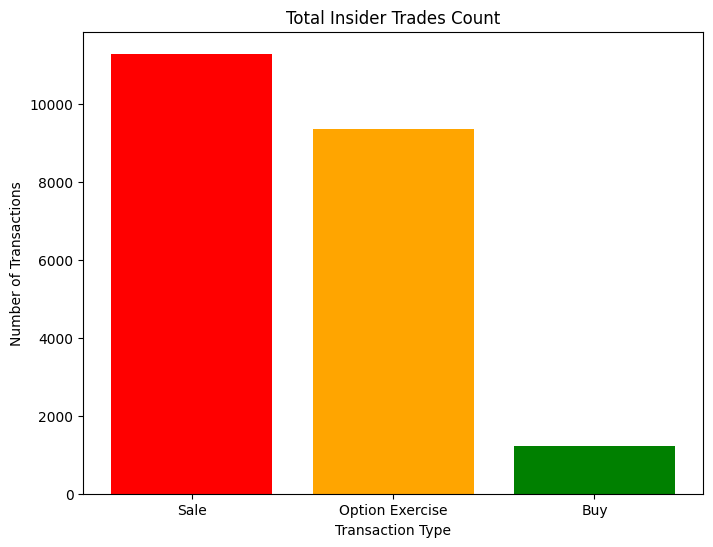

In [563]:
transaction_counts = insider_trading_tidy['transaction'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(transaction_counts.index, transaction_counts.values, color=['red', 'orange', 'green'])
plt.title('Total Insider Trades Count')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.show()

In the current case of the data, option exercise is either buy or sell, so that is of no use. In the further analysis, we will see, how stock prices behave, when exercising the option. If it goes down it will mean, that we have mostly sells. But we can obviously see, that we have much more sell orders than buy ones. Let's see moneywise, what is the difference.

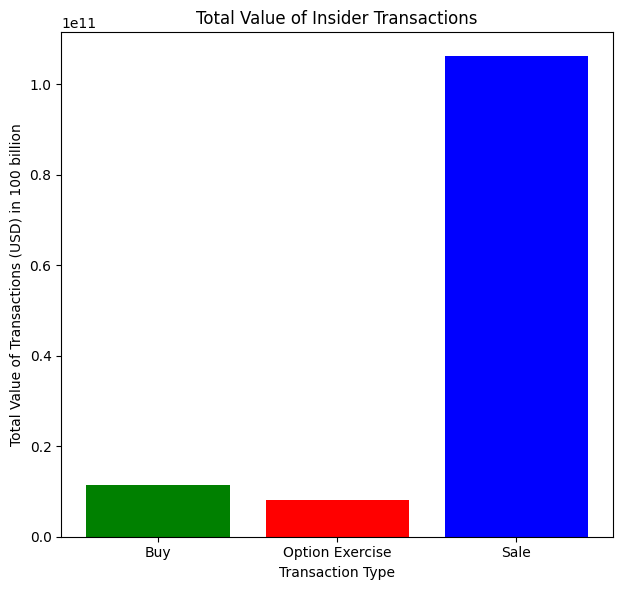

In [537]:
insider_trading_tidy['value'] = insider_trading_tidy['value'].replace('[\$,]', '', regex=True).astype(float)

transaction_counts = insider_trading_tidy['transaction'].value_counts()

transaction_values = insider_trading_tidy.groupby('transaction')['value'].sum()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.bar(transaction_values.index, transaction_values.values, color=['green', 'red', 'blue'])
plt.title('Total Value of Insider Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Total Value of Transactions (USD) in 100 billion')

plt.tight_layout()
plt.show()

Even though there are much fewer buy transaciton, moneywise, they are more than the option exercise, but still far less than the sale ones.

Now let's investigate companywise, what are the most insider traded stocks.

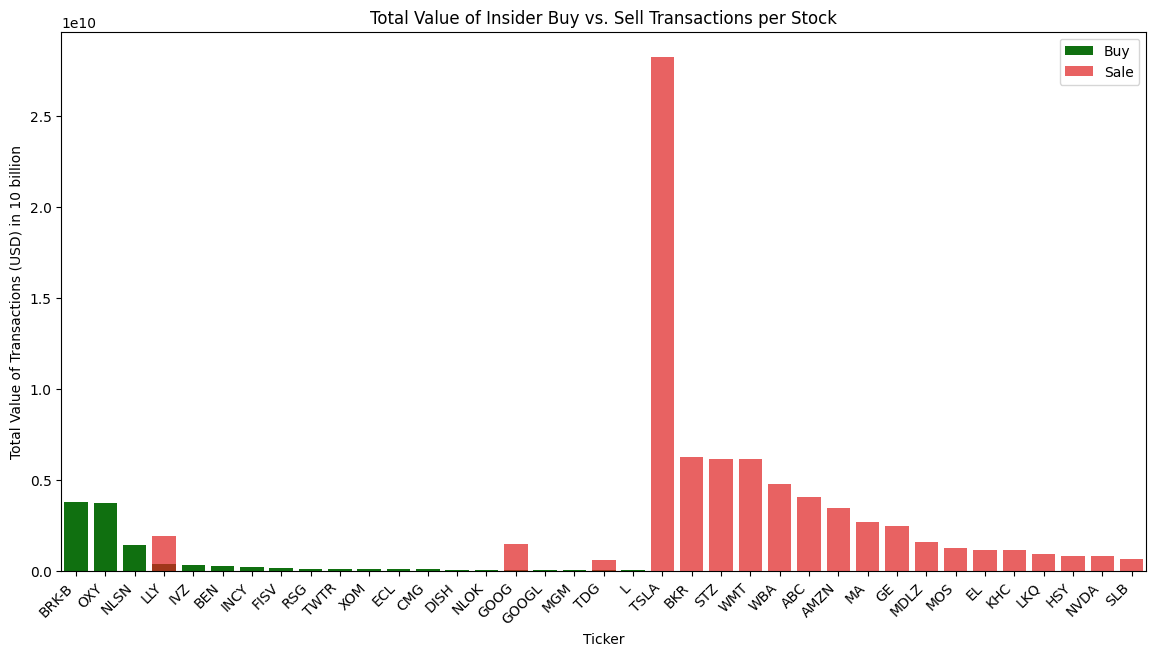

In [542]:
insider_trading_tidy['value'] = insider_trading_tidy['value'].replace('[\$,]', '', regex=True).astype(float)

# Sum the value of buy and sell transactions for each stock
transaction_value = insider_trading_tidy.groupby(['ticker', 'transaction'])['value'].sum().unstack(fill_value=0).reset_index()
most_buy_companies = transaction_value.sort_values(['Buy'], ascending=False).head(20)
most_sell_companies = transaction_value.sort_values(['Sale'], ascending=False).head(20)

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='ticker', y='Buy', data=most_buy_companies, color='green', label='Buy')
sns.barplot(x='ticker', y='Sale', data=most_sell_companies, color='red', label='Sale', alpha=0.7)
plt.title('Total Value of Insider Buy vs. Sell Transactions per Stock')
plt.xlabel('Ticker')
plt.ylabel('Total Value of Transactions (USD) in 10 billion')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

We can see, that Tesla is by far the most insider sold stock ever. What is interesting is that, LLY is the 4th most bough and the 10th most sold one. Also GOOG and TDG are in both lists. The most insider bough stock is BRK-B (Berkshire Hathaway B stocks), which is owned by Warren Buffet.

   3. **Financial Indicators**:
      
      - **Source**: [200 Financial Indicators of U.S. Stocks (2014-2018)](https://www.kaggle.com/datasets/cnic92/200-financial-indicators-of-us-stocks-20142018)

This dataset provides a wide range of financial indicators for U.S. stocks, covering metrics such as profitability, liquidity, leverage, and valuation from 2014 to 2018. These indicators are critical for assessing the financial health and performance of companies.

The dataset, that will be used can be found in the folder "financial_indicators". It contains information for 5 years (2014-2018) for many stocks. Lets read it.

In [412]:
folder_path = 'financial_indicators'
dataframes = []

for file_name in os.listdir(folder_path):
    year = file_name.split('_')[0]
    
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    
    df['year'] = int(year)
    
    dataframes.append(df)

financial_indicators = pd.concat(dataframes, ignore_index=True)

financial_indicators.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,year,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,0.0000,-0.1746,Consumer Defensive,-9.323276,0,2014,NaN,NaN,NaN,NaN
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,1.6484,1.7313,Consumer Defensive,-25.512193,0,2014,NaN,NaN,NaN,NaN
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0000,0.0234,Consumer Defensive,33.118297,1,2014,NaN,NaN,NaN,NaN
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0000,-0.0060,Consumer Defensive,2.752291,1,2014,NaN,NaN,NaN,NaN
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0000,-0.0220,Consumer Defensive,12.897715,1,2014,NaN,NaN,NaN,NaN


In [413]:
financial_indicators_tidy = financial_indicators
financial_indicators_tidy.columns = convert_to_snake_case(financial_indicators_tidy)

financial_indicators_tidy = financial_indicators_tidy.rename(columns={'unnamed:_0': 'ticker'})
print(list(financial_indicators_tidy.dtypes))
print(len(financial_indicators.groupby(financial_indicators_tidy.ticker)))
print(financial_indicators_tidy.columns)

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

This dataset contains a lot of columns and data about all the possible financial indicators of the stocks. The columns seem to be in the correct data types.

There are 4980 different stocks. In the above datasets we had only 503 most popular tickers, so we will investigate only the 503 we have the prices for.

   4. **Tweets for Sentiment Analysis**:
      
      - **Source**: [Stock Tweets for Sentiment Analysis and Prediction](https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction)
      
This dataset includes tweets related to stock market sentiment. Each tweet has a stock name attached to it. The dataset is useful for analyzing the correlation between social media sentiment and market movements.

Let's now read the data and see what we have.

In [414]:
tweet_data = pd.read_csv('tweet_data/stock_tweets.csv')

In [415]:
tweet_data_tidy = tweet_data

tweet_data_tidy.columns = convert_to_snake_case(tweet_data_tidy)

tweet_data_tidy.date = pd.to_datetime(tweet_data_tidy.date)

tweet_data_tidy = tweet_data_tidy.rename(columns={'stock_name': 'ticker'})

As we can see there are the tweets with their dates and the company, about which is the tweet. The data is from years 2021 - 2022.

In [416]:
tweet_data_tidy.ticker.value_counts()

ticker
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

There are 25 different stocks in the datasaet, the most tweets of which are about Tesla, which is quite normal, since the owner of twitter Elon Musk, also owns Tesla.

Sentiment analysis needs to be performed on the data and then inspect, whether the tweets affect the price.

   5. **Earnings Data**:

      - **Source**: [U.S. Historical Stock Prices with Earnings Data](https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data)

This dataset focuses on stock price movements around earnings announcements. It includes historical stock prices and earnings data, allowing for the analysis of how earnings reports impact stock prices both in the short-term and long-term.

In [417]:
earnings_data = pd.read_csv('earnings_data/earnings_latest.csv')
earnings_data

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post
...,...,...,...,...,...,...
168598,ZYXI,2020-02-27,Q4,0.077,0.09,post
168599,ZYXI,2020-04-28,Q1,0.063,0.09,post
168600,ZYXI,2020-07-28,Q2,0.086,0.09,post
168601,ZYXI,2020-10-27,Q3,0.053,0.04,post


This datasest will require a bit more preparation. Why do we need data without eps and eps_est. It is basically useless.

Also the quarters seem to be in all kind of different dates, but we arae not going to be using them in our research, since we only need the dates. Let's tidy the dataset.

In [418]:
earnings_data_tidy = earnings_data

earnings_data_tidy = earnings_data_tidy.rename(columns={'symbol': 'ticker'})

# Remove columns, where we don't have eps and eps_est
earnings_data_tidy = earnings_data_tidy.drop(earnings_data_tidy[(earnings_data_tidy.eps.isna()) | (earnings_data_tidy.eps_est.isna())].index)

# Drop quarter column, since we don't need it
earnings_data_tidy = earnings_data_tidy.drop(columns=['qtr'])

In [419]:
earnings_data_tidy.date = pd.to_datetime(earnings_data_tidy.date)

In [420]:
len(earnings_data_tidy.ticker.unique())

5075

In [421]:
earnings_data_tidy.date.min(), earnings_data_tidy.date.max()

(Timestamp('2012-07-16 00:00:00'), Timestamp('2021-06-14 00:00:00'))

We to have 5075 different tickers, with their corresponding earnings data and the dates are from 2012 up until mid 2021

## 3. Financial Statements and Long-term Stock Price Trends

Understanding the relationship between financial statements and stock price trends is crucial for both investors and analysts. Financial statements provide detailed information about a company’s financial health, including revenue, expenses, profitability, and cash flow. Among these, earnings reports are particularly significant because they offer insights into a company’s performance over a specific period, typically a quarter or a year.

Let's now do some analysis and figure out exactly how much the financial statements affects stock prices.

In [422]:
# Merge the stock and earnings data on ticker and date
stock_earning_data = pd.merge(stock_data_tidy, earnings_data_tidy, on=['ticker', 'date'])

In [423]:
stock_earning_data.sort_values(by=['ticker', 'date'], inplace=True)

In [424]:
event_window_start = -12
event_window_end = 12

In [425]:
stock_earning_data = stock_earning_data.drop(columns=['dividends', 'stock_splits'])

Add data for prices before and after each earnings. There is a difference between the release times. If the release time is 'pre', then we should get the day before the earnings report. If it is 'post', we should get the actual day of earnings.

In [426]:
stock_earning_data['current_date_price'] = stock_earning_data.apply(
    lambda row: row['date'] if row['release_time'] == 'post' else row['date'] - pd.Timedelta(days=1),
    axis=1
)

# Merge with stocks data to get the price and corresponding date on or before earnings date
stock_earning_data = pd.merge_asof(
    stock_earning_data.sort_values('current_date_price'),
    stock_data_tidy[['ticker', 'date', 'close']].sort_values('date'),
    left_on='current_date_price',
    right_on='date',
    by='ticker',
    direction='backward',
    suffixes=('', '_from_stock_data')
)
stock_earning_data.rename(columns={'close_from_stock_data': 'price_before_earnings'}, inplace=True)

Then we adjust the prices. We want to have consistency, since the stock market works only in working days and we should exclude Saturday, Sunday and holidays. For example 8 days before earnings, could be 10 days in real life. We want to get 8 days of trading, not holidays.

In [427]:
def check_before_or_after(day):
    return "before" if day < 0 else "after"

def adjust_and_merge_dates(data, stock_data, day):
    """
    Adjusts the dates and performs the merge operation for the given day.
    
    Parameters:
    - data: The DataFrame containing the merged data.
    - stock_data: The DataFrame containing the stock data.
    - day: The day offset to adjust and merge.
    
    Returns:
    - stock_earning_data: The updated DataFrame with merged and adjusted dates.
    """
    date_column = f'temp_date_{abs(day)}_days_{check_before_or_after(day)}'
    
    # Adjust the date based on whether it's before or after the event
    if check_before_or_after(day) == 'before':
        adjusted_date = (data['current_date_price'] + pd.Timedelta(days=day)) if day >= -1 else data[f'date_{abs(day+1)}_days_{check_before_or_after(day)}'] + pd.Timedelta(days=-1)
    else:  # after
        adjusted_date = (data['current_date_price'] + pd.Timedelta(days=day)) if day <= 1 else data[f'date_{abs(day-1)}_days_{check_before_or_after(day)}'] + pd.Timedelta(days=1)

    data[date_column] = adjusted_date

    # Merge to find the closest available date with data in stock data
    data = pd.merge_asof(
        data.sort_values(date_column),
        stock_data[['ticker', 'date', 'close']].sort_values('date'),
        left_on=date_column,
        right_on='date',
        by='ticker',
        direction='backward' if day < 0 else 'forward',
        suffixes=('', f'_{abs(day)}_days_{check_before_or_after(day)}')
    )

    new_column_name = f'price_{abs(day)}_days_{check_before_or_after(day)}'
    data.rename(columns={f'close_{abs(day)}_days_{check_before_or_after(day)}': new_column_name}, inplace=True)

    # Restore the original 'date' column from the date_column used for merging
    data[date_column] = data['date']

    # Drop the temporary date column after merging
    data.drop(columns=[date_column], inplace=True)

    return data

In [428]:
for day in range(-1, event_window_start - 1, -1):
    stock_earning_data = adjust_and_merge_dates(stock_earning_data, stock_data_tidy, day)

for day in range(0, event_window_end + 1, 1):
    stock_earning_data = adjust_and_merge_dates(stock_earning_data, stock_data_tidy, day)

In [429]:
def calculate_diff_percent(first, second, threshold=1e-5):
    if abs(second) < threshold:
        return 0  # Avoid division by zero or near-zero
    else:
        return ((first - second) / abs(second)) * 100

In [430]:
stock_earning_data['eps_diff_percent'] = stock_earning_data.apply(
    lambda row: calculate_diff_percent(row['eps'], row['eps_est'], 1e-5), axis=1
)

Lets remove the percentages > 2000 and < 2000, since they are very few of then and are more of an outliers.

In [431]:
len(stock_earning_data[(stock_earning_data.eps_diff_percent < -2000) | (stock_earning_data.eps_diff_percent > 2000)])

13

In [432]:
stock_earning_data = stock_earning_data.drop(stock_earning_data[(stock_earning_data.eps_diff_percent < -2000) | (stock_earning_data.eps_diff_percent > 2000)].index)

Next let's categorize the eps differences. 0.5% will be the neutral mark.

In [433]:
neutral_threshold = 0.5 

stock_earning_data['eps_category'] = np.where(
    stock_earning_data['eps_diff_percent'] > neutral_threshold, 'Positive Surprise',
    np.where(
        stock_earning_data['eps_diff_percent'] < -neutral_threshold, 'Negative Surprise',
        'Near Zero'
    )
)

Next up let's find the percentage differences between the prices each day. We compare with the price before earnings, since it is most accurate measurement and we can easily plot it.

In [434]:
def calculate_percentage_changes(data, price_column):
    """
    Calculate the percentage change for each day before and after the earnings announcement.

    Parameters:
    - data: DataFrame containing stock data and earnings information.
    - price_column: The column name of the price

    Returns:
    - The updated DataFrame with calculated percentage changes for each day before and after the event.
    """
    for day in range(1, event_window_end):
        data[f'change_{day}_days_before'] = data.apply(
            lambda row: calculate_diff_percent(row[f'price_{day}_days_before'], row[price_column]), axis=1
        )

        data[f'change_{day}_days_after'] = data.apply(
            lambda row: calculate_diff_percent(row[f'price_{day}_days_after'], row[price_column]), axis=1
        )

    return data

In [435]:
# Calculate the percentage change for each day before and after the earnings announcement
stock_earning_data = calculate_percentage_changes(stock_earning_data, 'price_before_earnings')

We finally have all the data we need. Let's do some plotting and investigating.

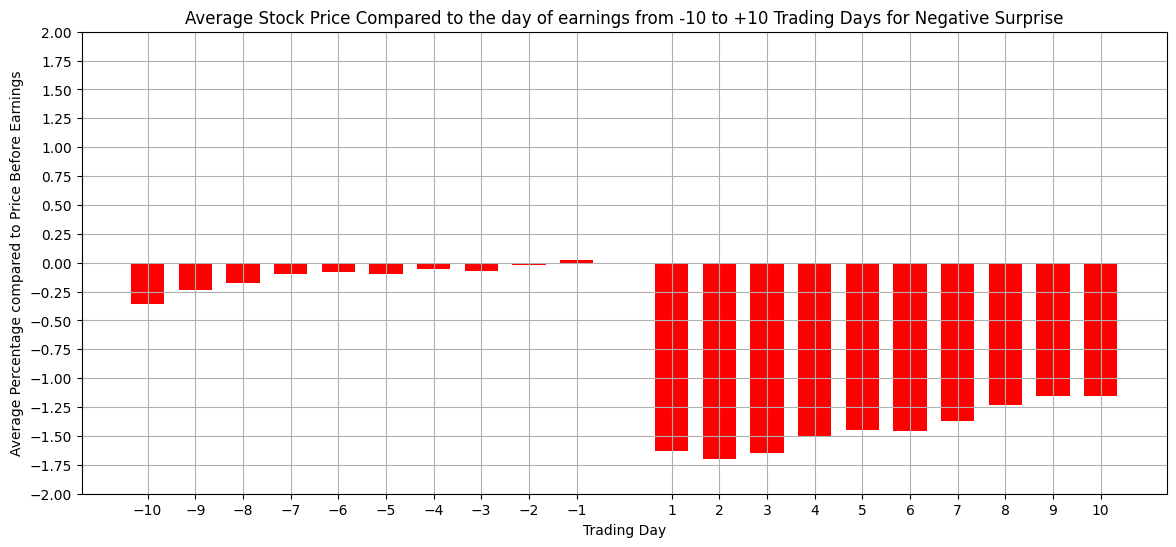

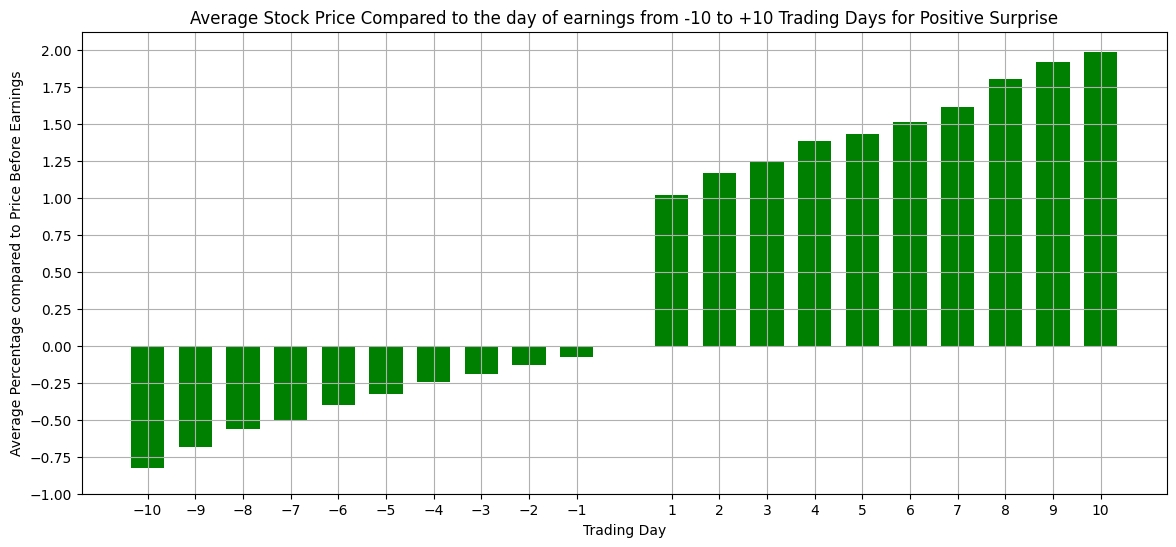

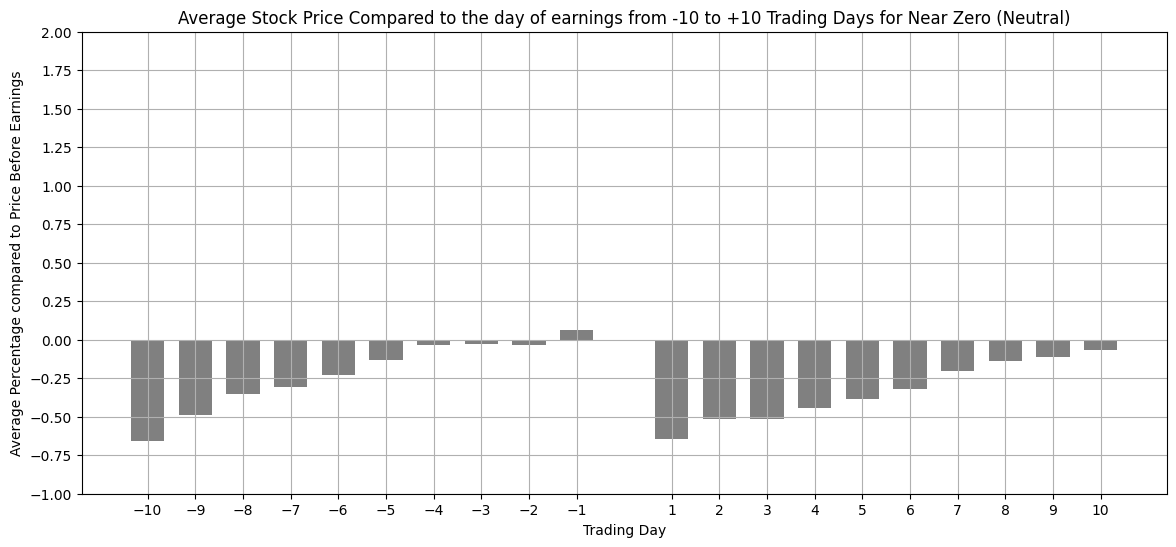

In [436]:
def plot_avg_changes(data, category, color, title = None, y_min = -1):
    """
    Plot average stock price changes before and after earnings for a given category.

    Parameters:
    - data: DataFrame containing the filtered data for the category.
    - category: String name of the category (e.g., 'Negative Surprise').
    - color: Color for the 'After Earnings' bars.
    - title: Custom title for the plot.
    - y_min: The minimum value for the y axis.
    """
    percentage_changes = []

    # Calculate average changes from 10 days before to 10 days after earnings
    for day in range(10, 0, -1):  # Days before earnings (negative days)
        avg_before = data[f'change_{day}_days_before'].mean()
        percentage_changes.append(avg_before)
    
    for day in range(1, 11):  # Days after earnings (positive days)
        avg_after = data[f'change_{day}_days_after'].mean()
        percentage_changes.append(avg_after)

    days = np.concatenate((np.arange(-10, 0), np.arange(1, 11)))  # Days from -10 to +10

    plt.figure(figsize=(14, 6))

    plt.bar(days, percentage_changes, width=0.7, color=color)

    plt.title(title if title != None else  f'Average Stock Price Compared to the day of earnings from -10 to +10 Trading Days for {category}')
    plt.xlabel('Trading Day')
    plt.ylabel('Average Percentage compared to Price Before Earnings')
    plt.xticks(days)
    plt.yticks(np.arange(y_min, 2.25, step=0.25))
    plt.grid(True)
    plt.show()

# Filter data for each category
negative_surprise_data = stock_earning_data[stock_earning_data['eps_category'] == 'Negative Surprise']
positive_surprise_data = stock_earning_data[stock_earning_data['eps_category'] == 'Positive Surprise']
neutral_data = stock_earning_data[stock_earning_data['eps_category'] == 'Near Zero']

plot_avg_changes(negative_surprise_data, 'Negative Surprise', 'red', None, -2)

plot_avg_changes(positive_surprise_data, 'Positive Surprise', 'green')

plot_avg_changes(neutral_data, 'Near Zero (Neutral)', 'gray')

From the above charts we can conclude, that  the earnings for sure have an effect on the stock price.

The correlation between negative earnings per share surprise leading to stock price plummet is as obvious as the correlation between the positive eps surpise and stock price rising. An interesting case is the around zero eps, where the price falls a bit, but recovers very quickly.

We can see, that people are mostly optimistic before the earnings report, as the prices rise and then after the earnings there is a big swing in either direction.

In the dataset we had data about the release time of the earnings report. Let's see, what is the difference between post and pre trading hours earnings reports. Beware, that most big companies do release their reports after the trading hours, although there are always some exception. So we would expect smaller companies to release their financial beforehand.

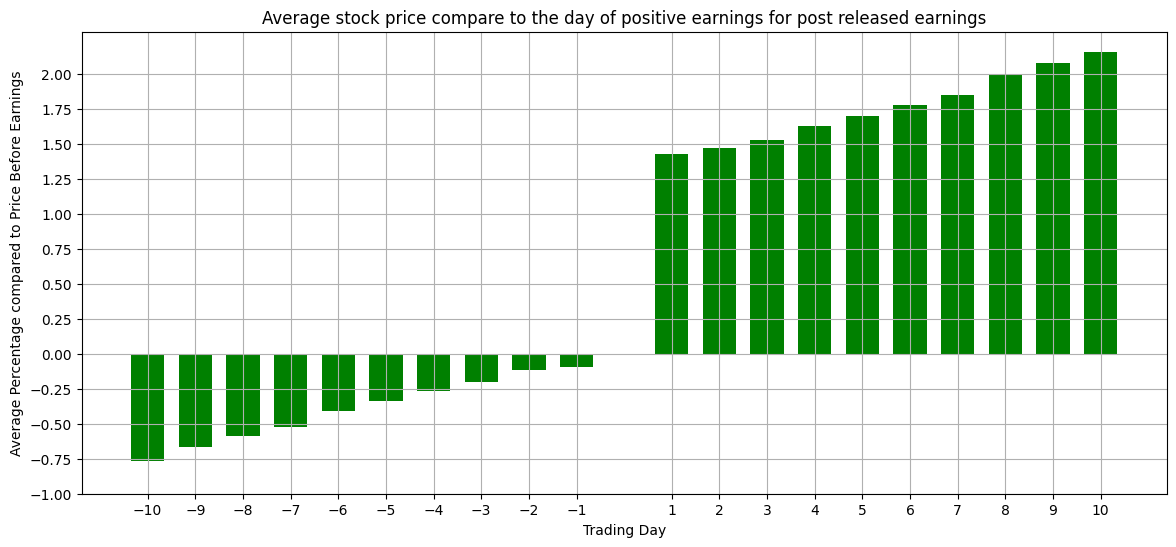

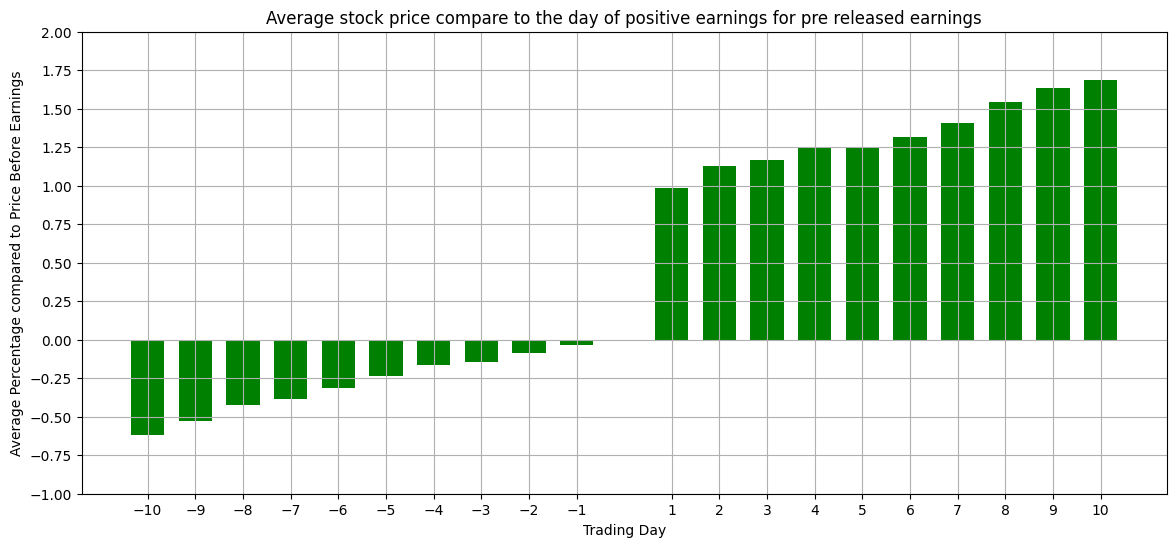

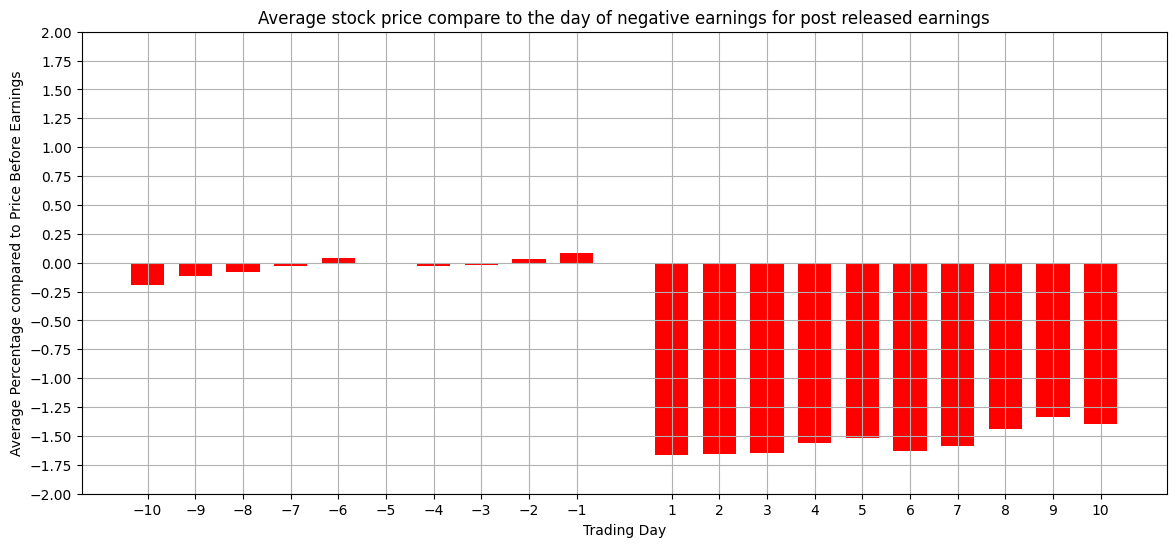

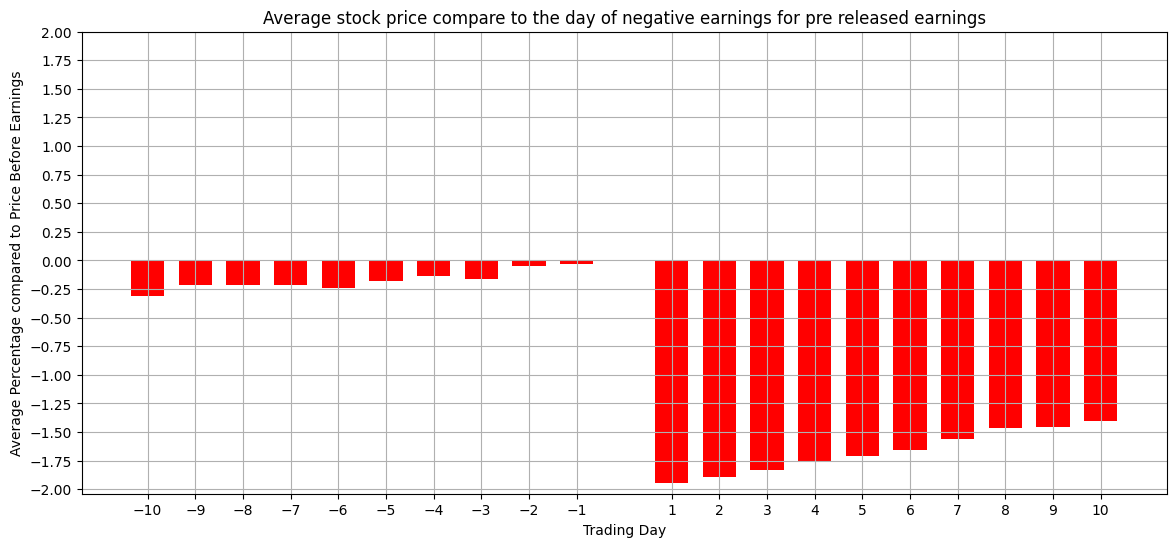

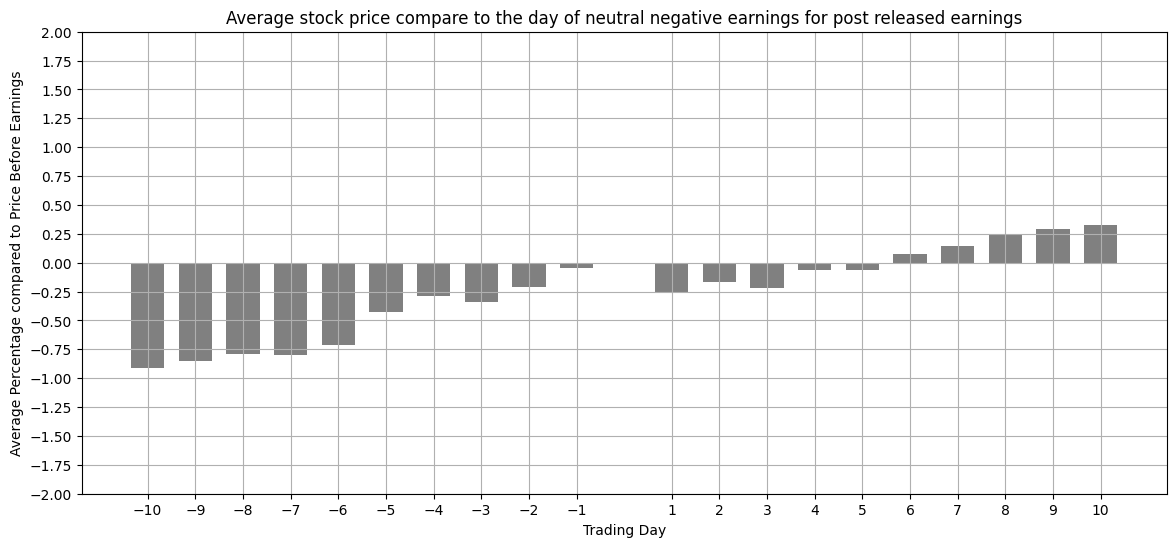

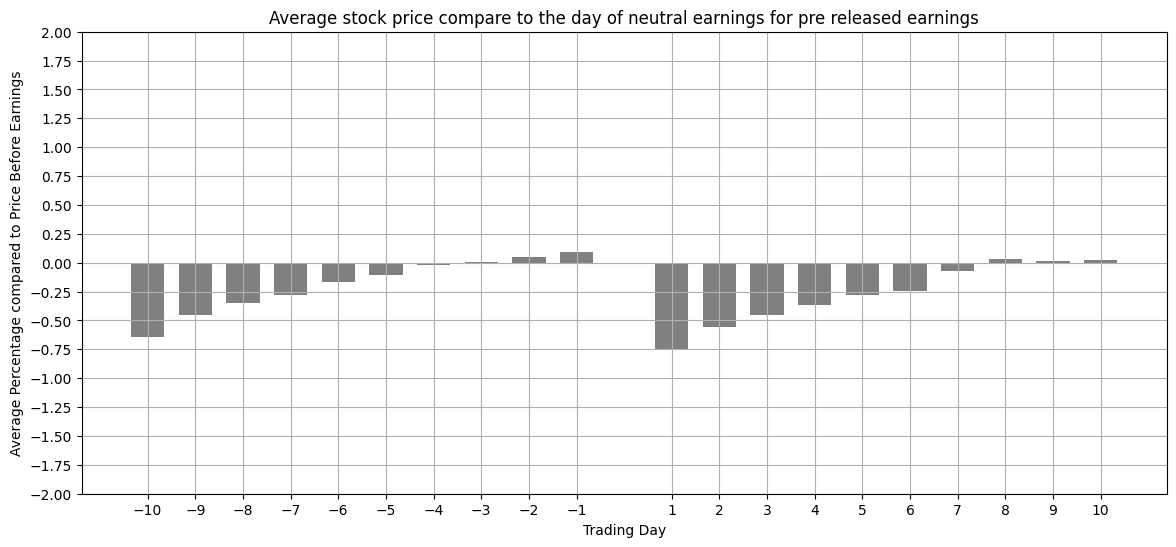

In [437]:
plot_avg_changes(positive_surprise_data[positive_surprise_data.release_time == 'post'], 'Positive Surprise', 'green', 'Average stock price compare to the day of positive earnings for post released earnings')
plot_avg_changes(positive_surprise_data[positive_surprise_data.release_time == 'pre'], 'Positive Surprise', 'green', 'Average stock price compare to the day of positive earnings for pre released earnings')

plot_avg_changes(negative_surprise_data[negative_surprise_data.release_time == 'post'], 'Negative Surprise', 'red', 'Average stock price compare to the day of negative earnings for post released earnings', -2)
plot_avg_changes(negative_surprise_data[negative_surprise_data.release_time == 'pre'], 'Negative Surprise', 'red', 'Average stock price compare to the day of negative earnings for pre released earnings', -2)


plot_avg_changes(neutral_data[neutral_data.release_time == 'post'], 'Negative Surprise', 'gray', 'Average stock price compare to the day of neutral negative earnings for post released earnings', -2)
plot_avg_changes(neutral_data[neutral_data.release_time == 'pre'], 'Negative Surprise', 'gray', 'Average stock price compare to the day of neutral earnings for pre released earnings', -2)

We can again observe the obvious pattern, that the stock prices go up before the earnings and afterwards swing in some direction. 
, 
In the cases of negative and neutral earnings, the pre release time seems to be more volatile with a lot more movement in the stock. While in the postive earnings it is the opposite. That maybe due to the fact, that as we mentioned, these are smaller companies and when big investors see small companies do good, they invest into them. While in bigger companies it is more difficult to attract such big attention to have such a move.

Now let's observe some distributions.

In [438]:
stock_earning_data['earliest_available_price'] = stock_earning_data[
    ['price_10_days_after', 'price_9_days_after', 'price_8_days_after', 'price_7_days_after', 
     'price_6_days_after', 'price_5_days_after', 'price_4_days_after', 'price_3_days_after', 
     'price_2_days_after', 'price_1_days_after']
].bfill(axis=1).iloc[:, 0]

In [439]:
stock_earning_data['total_change_after_10_days'] = stock_earning_data.apply(
        lambda row: calculate_diff_percent(row['earliest_available_price'], row['price_before_earnings']), axis=1
)

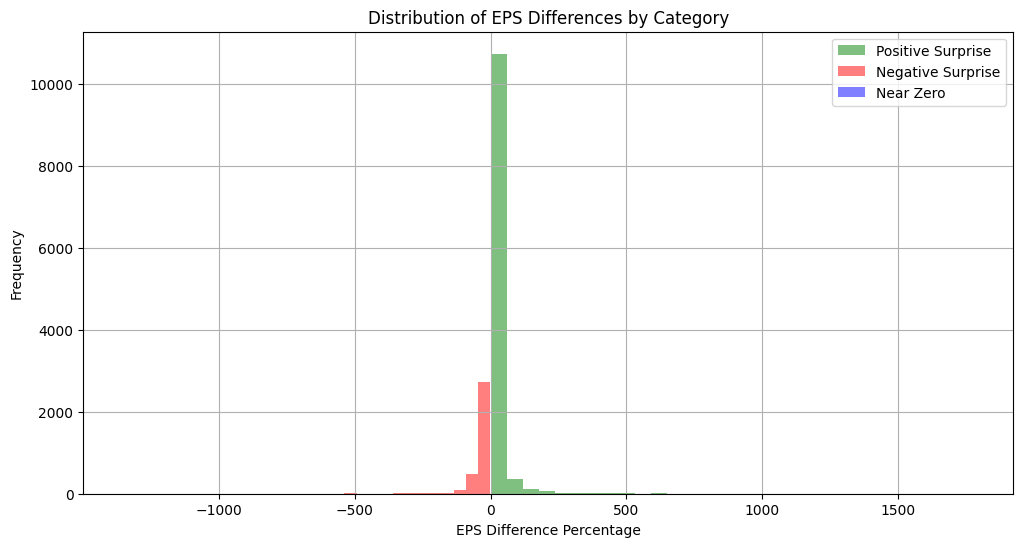

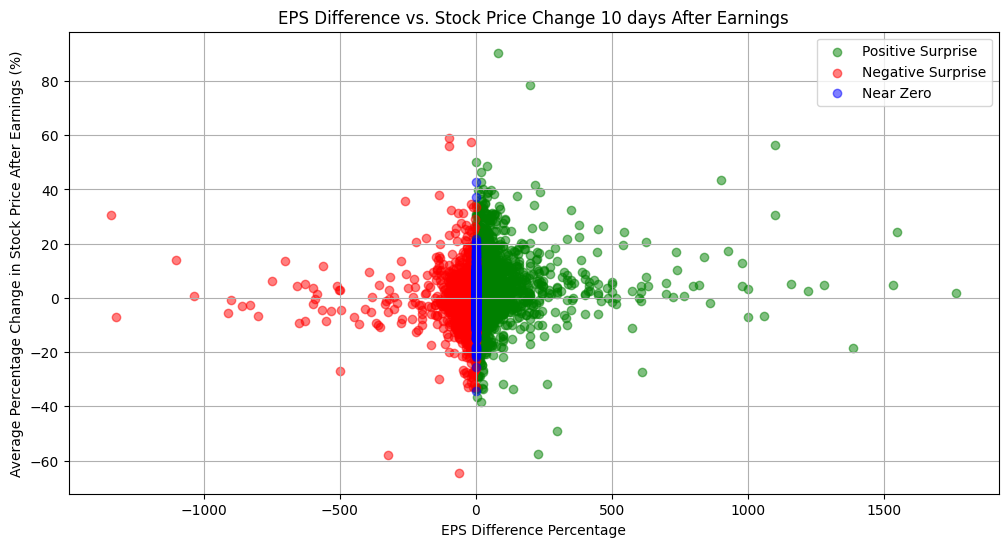

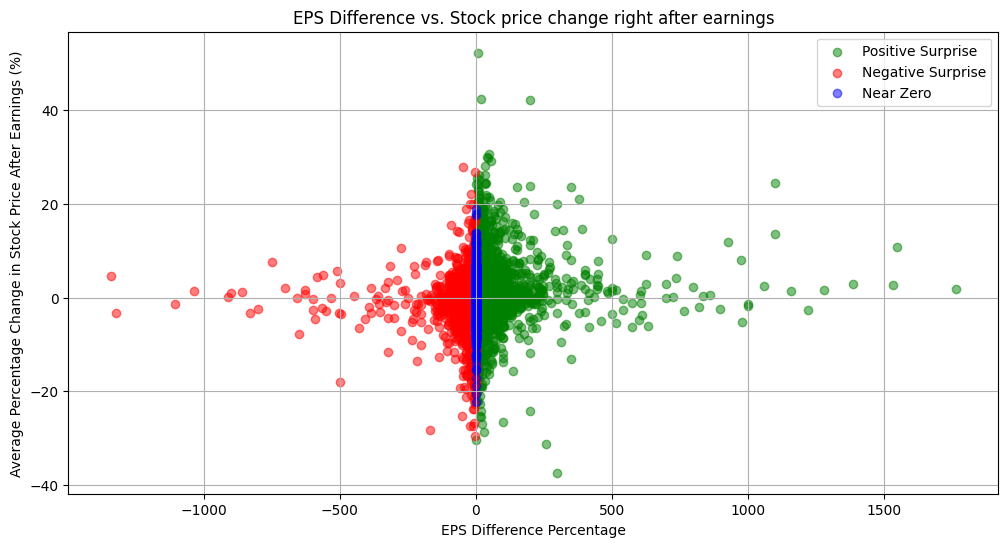

In [440]:
plt.figure(figsize=(12, 6))

if not stock_earning_data[stock_earning_data['eps_category'] == 'Positive Surprise']['eps_diff_percent'].empty:
    plt.hist(stock_earning_data[stock_earning_data['eps_category'] == 'Positive Surprise']['eps_diff_percent'], bins=30, alpha=0.5, label='Positive Surprise', color='green')

if not stock_earning_data[stock_earning_data['eps_category'] == 'Negative Surprise']['eps_diff_percent'].empty:
    plt.hist(stock_earning_data[stock_earning_data['eps_category'] == 'Negative Surprise']['eps_diff_percent'], bins=30, alpha=0.5, label='Negative Surprise', color='red')

if not stock_earning_data[stock_earning_data['eps_category'] == 'Near Zero']['eps_diff_percent'].empty:
    plt.hist(stock_earning_data[stock_earning_data['eps_category'] == 'Near Zero']['eps_diff_percent'], bins=30, alpha=0.5, label='Near Zero', color='blue')

plt.title('Distribution of EPS Differences by Category')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Scatter plot of EPS differences vs. average stock price change after earnings
plt.figure(figsize=(12, 6))

categories = ['Positive Surprise', 'Negative Surprise', 'Near Zero']
colors = ['green', 'red', 'blue']

for category, color in zip(categories, colors):
    subset = stock_earning_data[stock_earning_data['eps_category'] == category]
    if not subset.empty:
        plt.scatter(subset['eps_diff_percent'], subset['total_change_after_10_days'], alpha=0.5, label=category, color=color)

plt.title('EPS Difference vs. Stock Price Change 10 days After Earnings')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Average Percentage Change in Stock Price After Earnings (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for category, color in zip(categories, colors):
    subset = stock_earning_data[stock_earning_data['eps_category'] == category]
    if not subset.empty:
        plt.scatter(subset['eps_diff_percent'], subset['change_1_days_after'], alpha=0.5, label=category, color=color)

plt.title('EPS Difference vs. Stock price change right after earnings')
plt.xlabel('EPS Difference Percentage')
plt.ylabel('Average Percentage Change in Stock Price After Earnings (%)')
plt.legend()
plt.grid(True)
plt.show()

In the first chart we can observer how stock prices react immediately to earnings surprises, while the second chart shows that these effects often persist over a 10-day period. Positive surprises generally lead to sustained price increases, while negative surprises result in lasting declines.

The market tends to react to earnings surprises, depending on the result. The scatter plots and histogram together suggest that the magnitude of the EPS surprise has a strong correlation with stock price movements, both immediately after the earnings and over the subsequent days.

The histogram shows that most earnings results are close to expectations, but when there are surprises, they can significantly impact stock prices.

## 4. Investigating the Effect of Insider Trading on Stock Prices

Insider trading offers valuable insights into a company’s stock performance. Insiders, such as executives, directors, and significant shareholders, often possess detailed knowledge about their company’s financial health and future prospects. When they buy or sell shares, they may use the greater information they have, potentially signaling the company's situation. They could also be bluffing, if they are a shareholder, wanting the company to grow. They might buy some shares, even though things don't look too good. The goal is to analyze stock prices after insider trades and see whether they really influence the market. The assumption is that after an insider trade, the stop will move in the direction of the trade most of the times.

In [441]:
insider_stock_data = pd.merge(insider_trading_tidy, stock_data_tidy, on=['ticker', 'date'], how='inner')

We need to remove all the data after mid June 2022, since our stock data is non existant and we will be left with just under 15k rows.

In [442]:
insider_stock_data = insider_stock_data.drop(insider_stock_data[insider_stock_data.date >= '2022-06-15'].index)

For our code, that we have written, we need a column named current_price_date, in order to reuse it.

In [443]:
insider_stock_data['current_date_price'] = insider_stock_data.date

Calculate the prices before and after the insider trade.

In [444]:
for day in range(-1, event_window_start - 1, -1):
    insider_stock_data = adjust_and_merge_dates(insider_stock_data, stock_data_tidy, day)

for day in range(0, event_window_end + 1, 1):
    insider_stock_data = adjust_and_merge_dates(insider_stock_data, stock_data_tidy, day)

In [445]:
insider_stock_data = calculate_percentage_changes(insider_stock_data, 'close')

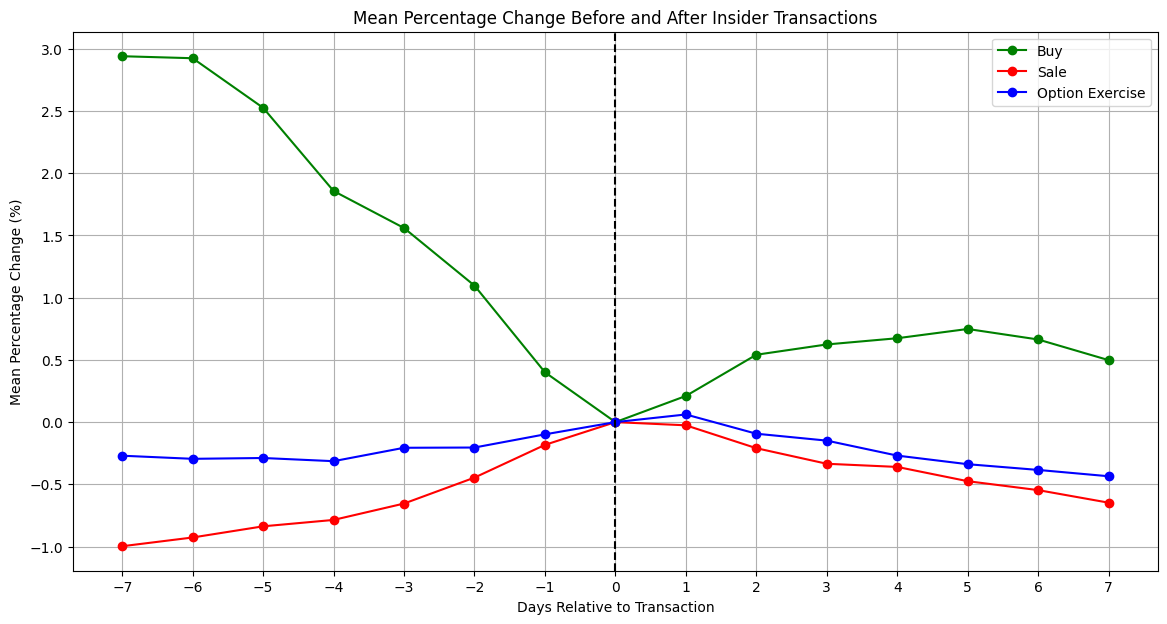

In [446]:
buy_data = insider_stock_data[insider_stock_data['transaction'] == 'Buy']
sale_data = insider_stock_data[insider_stock_data['transaction'] == 'Sale']
option_exercise_data = insider_stock_data[insider_stock_data['transaction'] == 'Option Exercise']

# Calculate mean percentage change for each day before and after the transaction (7 days)
days = list(range(-7, 8))

# Calculate means for Buy transactions
buy_means_before = [buy_data[f'change_{abs(day)}_days_before'].mean() for day in range(7, 0, -1)]
buy_means_after = [buy_data[f'change_{day}_days_after'].mean() for day in range(1, 8)]
buy_means = buy_means_before + [0] + buy_means_after  # Combine before, 0, and after

# Calculate means for Sale transactions
sale_means_before = [sale_data[f'change_{abs(day)}_days_before'].mean() for day in range(7, 0, -1)]
sale_means_after = [sale_data[f'change_{day}_days_after'].mean() for day in range(1, 8)]
sale_means = sale_means_before + [0] + sale_means_after

# Calculate means for Option Exercise transactions
option_exercise_means_before = [option_exercise_data[f'change_{abs(day)}_days_before'].mean() for day in range(7, 0, -1)]
option_exercise_means_after = [option_exercise_data[f'change_{day}_days_after'].mean() for day in range(1, 8)]
option_exercise_means = option_exercise_means_before + [0] + option_exercise_means_after

plt.figure(figsize=(14, 7))

# Plot for Buy transactions
plt.plot(days, buy_means, marker='o', linestyle='-', color='green', label='Buy')

# Plot for Sale transactions
plt.plot(days, sale_means, marker='o', linestyle='-', color='red', label='Sale')

# Plot for Option transactions
plt.plot(days, option_exercise_means, marker='o', linestyle='-', color='blue', label='Option Exercise')

plt.title('Mean Percentage Change Before and After Insider Transactions')
plt.xlabel('Days Relative to Transaction')
plt.ylabel('Mean Percentage Change (%)')
plt.xticks(days)
plt.axvline(0, color='black', linestyle='--')  # Vertical line at the transaction day (day 0)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

As we can see in the plot, insider trades lead to price changes in the stock. When a shareholder buys a stock, the price usually starts climbing a bit. Meanwhile when they sell a share, we can observer, that the price falls in the next couple of days. Their impact is not as significant as the earnings report, but they can influence the market.

Option exercises in our dataset seem to be more related in sell operations, since when a shareholder exercises his option, then the price seems to go down just a bit.

## 5. Analyzing the Impact of Tweets on Stock Prices

First of all, let's perform a sentiment analysis on the data.

In [447]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

tweet_data_tidy['sentiment'] = tweet_data_tidy['tweet'].apply(get_sentiment)

print(tweet_data_tidy[['tweet', 'sentiment']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andon\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                                                                                                                                                                                                                                                              tweet  \
0  Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in &amp; I said @Tesla because they make the safest cars &amp; EVERYONE disagreed with me because they heard“they catch on fire &amp; the batteries cost 20k to replace”   
1                                                                                                                                                                                                                              Tesla delivery estimates are at around 364k from the analysts. $tsla   
2                                      3/ Even if I include 63.0M unvested RSUs as of 6/30, additional equity neede

In [448]:
pd.set_option('display.max_colwidth', None)
tweet_data_tidy[['tweet', 'sentiment']]

,tweet,sentiment
0,"Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in &amp; I said @Tesla because they make the safest cars &amp; EVERYONE disagreed with me because they heard“they catch on fire &amp; the batteries cost 20k to replace”",0.0772
1,Tesla delivery estimates are at around 364k from the analysts. $tsla,0.0000
2,"3/ Even if I include 63.0M unvested RSUs as of 6/30, additional equity needed for the RSUs is 63.0M x $54.20 = $3.4B. If the deal closed tomorrow at $54.20, Elon would need $2.0B for existing shares plus $3.4B for RSUs, so $5.4B new equity. $twtr $tsla",0.2960
3,"@RealDanODowd @WholeMarsBlog @Tesla Hahaha why are you still trying to stop Tesla FSD bro! Get your shit together and make something better? Thats how companies work, they competed. Crying big old ass fart clown!",-0.7568
4,"@RealDanODowd @Tesla Stop trying to kill kids, you sad deranged old man",-0.8750
...,...,...
80788,Some of the fastest growing tech stocks on the market. Mix of #Fintech #Adtech and #EV. \n$UPST $XPEV $APPS $LI $Z https://t.co/ETBO02tD7U,0.1779
80789,"With earnings on the horizon, here is a quick snapshot of some of the largest increases in consensus topline estimates over the last 30 days for tech growth stocks. $STEM $BILL $XPEV $TRMR $OPEN $MNDY $S $AMKR $ASAN $FTCH https://t.co/yk43Ulf580",0.3818
80790,"Our record delivery results are a testimony of our unwavering pursuit of safety, quality, and customer experience. Details of Sep delivery results here: https://t.co/UbZCyRZvRZ. $XPEV #ElectricVehicles https://t.co/1nTbrL03no",0.4215
80791,"We delivered 10,412 Smart EVs in Sep 2021, reaching the milestone of 10,000-unit monthly deliveries. We believe that technology will reshape our future mobility, and we put effort into making it happen. $XPEV\n#SmartMobility #ElectricCars #GoElectric #ElectricVehicles https://t.co/bTmYqbGTXQ",0.5423


As we can read the tweets, the sentiment seem correctly added. Lets see how the sentiments for the different tickers look like

In [449]:
tweet_data_tidy['date'] = pd.to_datetime(tweet_data['date'])

# Aggregate sentiment by date and ticker
stock_sentiments = tweet_data_tidy.groupby(['ticker'])['sentiment'].mean().reset_index()

print(stock_sentiments)

   ticker  sentiment
0    AAPL   0.135910
1     AMD   0.271064
2    AMZN   0.184484
3      BA   0.181963
4      BX   0.311492
5    COST   0.183776
6     CRM   0.209566
7     DIS   0.130214
8    ENPH   0.314981
9       F   0.104887
10   GOOG   0.194167
11   INTC   0.172735
12     KO   0.233777
13   META   0.151807
14   MSFT   0.184484
15   NFLX   0.095277
16    NIO   0.233216
17    NOC   0.104887
18     PG   0.184484
19   PYPL   0.191121
20   TSLA   0.161892
21    TSM   0.204982
22     VZ   0.247242
23   XPEV   0.283682
24     ZS   0.289269


We can see, that the average sentiments of all stocks are generally positive, so people just have a positive attitude as usual.

In [450]:
# Modify the date column to only keep the date part (year, month, day)
tweet_data_tidy['date'] = tweet_data_tidy.date.dt.date

daily_sentiment = tweet_data_tidy.groupby(['date', 'ticker'])['sentiment'].mean().reset_index()

Let's see the sentiments per day per stock

In [451]:
print(daily_sentiment)

            date ticker  sentiment
0     2021-09-30   AAPL   0.098900
1     2021-09-30    AMD   0.417800
2     2021-09-30   AMZN   0.246480
3     2021-09-30    DIS   0.546100
4     2021-09-30   GOOG   0.440400
...          ...    ...        ...
5905  2022-09-29     PG   0.117650
5906  2022-09-29   PYPL   0.630000
5907  2022-09-29   TSLA   0.062029
5908  2022-09-29    TSM   0.155219
5909  2022-09-29     ZS   0.000000

[5910 rows x 3 columns]


In [452]:
daily_sentiment.date = pd.to_datetime(daily_sentiment.date)

In [453]:
sentiment_stocks = pd.merge(daily_sentiment, stock_data_tidy, on=['date', 'ticker'])

sentiment_stocks = sentiment_stocks.sort_values(by=['ticker', 'date'])

sentiment_stocks['price_change'] = sentiment_stocks.groupby('ticker')['close'].pct_change() * 100

print(sentiment_stocks.head())

         date ticker  sentiment        open        high         low  \
0  2021-09-30   AAPL   0.098900  143.057918  143.774902  140.687888   
10 2021-10-01   AAPL   0.291891  141.305283  142.321012  138.526982   
21 2021-10-04   AAPL   0.047410  141.165869  141.613995  137.690505   
33 2021-10-05   AAPL   0.139060  138.905410  141.643885  138.775950   
46 2021-10-06   AAPL   0.190330  138.885481  141.554242  137.790085   

         close      volume  dividends  stock_splits  price_change  
0   140.906967  89056700.0        NaN           NaN           NaN  
10  142.052139  94639600.0        NaN           NaN      0.812715  
21  138.556854  98322000.0        NaN           NaN     -2.460565  
33  140.518616  80861100.0        NaN           NaN      1.415853  
46  141.404877  83221100.0        NaN           NaN      0.630707  


In [454]:
sentiment_stocks[sentiment_stocks.ticker == 'TSLA']

,date,ticker,sentiment,open,high,low,close,volume,dividends,stock_splits,price_change
9,2021-09-30,TSLA,0.231552,781.000000,789.130005,775.000000,775.479980,17956000.0,NaN,NaN,NaN
20,2021-10-01,TSLA,0.233704,778.400024,780.780029,763.590027,775.219971,17031400.0,NaN,NaN,-0.033529
32,2021-10-04,TSLA,0.135388,796.500000,806.969971,776.119995,781.530029,30483300.0,NaN,NaN,0.813970
45,2021-10-05,TSLA,0.069445,784.799988,797.309998,774.200012,780.590027,18432600.0,NaN,NaN,-0.120277
58,2021-10-06,TSLA,0.199940,776.200012,786.659973,773.219971,782.750000,14632800.0,NaN,NaN,0.276710
...,...,...,...,...,...,...,...,...,...,...,...
2632,2022-07-06,TSLA,0.188145,692.340027,703.690002,681.559998,695.200012,23951200.0,NaN,NaN,-0.572082
2648,2022-07-07,TSLA,0.050548,701.760010,736.090027,696.630005,733.630005,27310200.0,NaN,NaN,5.527904
2662,2022-07-08,TSLA,0.224756,727.000000,764.940002,723.479980,752.289978,33343700.0,NaN,NaN,2.543513
2676,2022-07-11,TSLA,0.096114,756.309998,759.190002,700.880005,703.030029,33080400.0,NaN,NaN,-6.548000


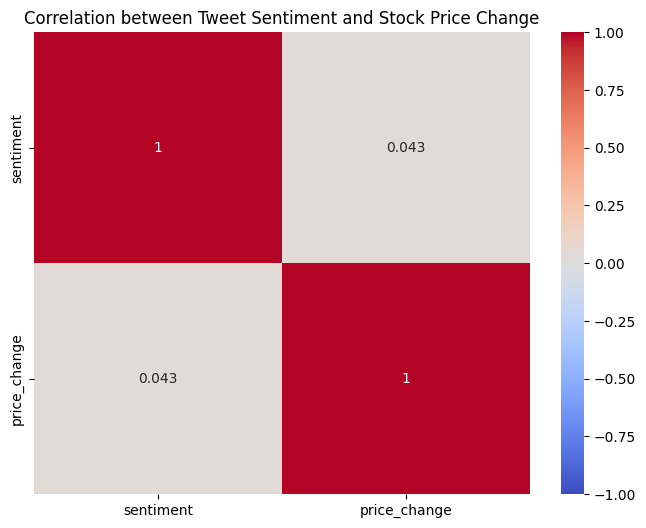

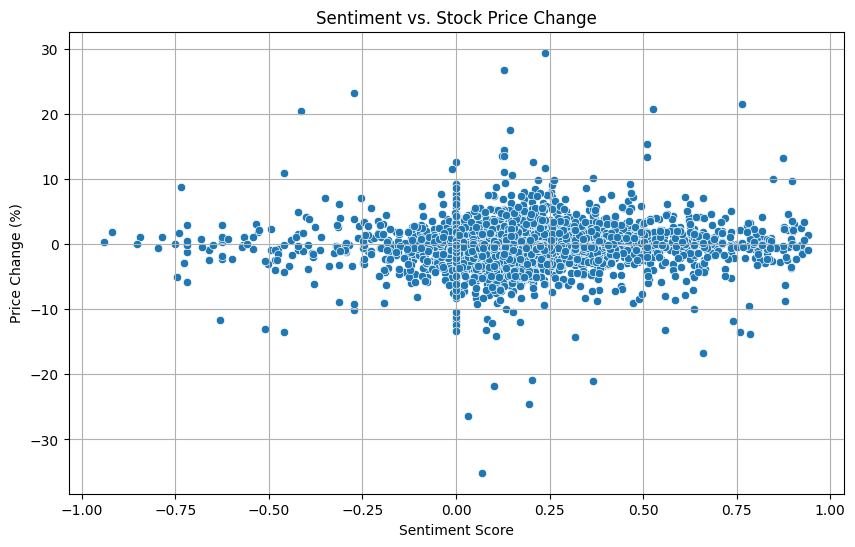

In [455]:
# Calculate the correlation matrix
correlation_matrix = sentiment_stocks[['sentiment', 'price_change']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Tweet Sentiment and Stock Price Change')
plt.show()

# Scatter plot to visualize sentiment vs. price change
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment', y='price_change', data=sentiment_stocks)
plt.title('Sentiment vs. Stock Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()

We did the analysis with mean values, instead of having in mind the count of the tweets per day. Although we see a bit of a correlation, it is not that high to conclude anything. Let's try to add weighted sentiment, based on the count of tweets.

In [456]:
# Group by date and ticker to calculate the mean sentiment and count of tweets
daily_sentiment = tweet_data_tidy.groupby(['date', 'ticker']).agg(
    mean_sentiment=('sentiment', 'mean'),
    tweet_count=('sentiment', 'size'),
    weighted_sentiment=('sentiment', lambda x: (x * x.size).sum() / x.size)
).reset_index()

print(daily_sentiment)

            date ticker  mean_sentiment  tweet_count  weighted_sentiment
0     2021-09-30   AAPL        0.098900            7              0.6923
1     2021-09-30    AMD        0.417800            6              2.5068
2     2021-09-30   AMZN        0.246480            5              1.2324
3     2021-09-30    DIS        0.546100            1              0.5461
4     2021-09-30   GOOG        0.440400            1              0.4404
...          ...    ...             ...          ...                 ...
5905  2022-09-29     PG        0.117650           10              1.1765
5906  2022-09-29   PYPL        0.630000            1              0.6300
5907  2022-09-29   TSLA        0.062029          112              6.9472
5908  2022-09-29    TSM        0.155219           16              2.4835
5909  2022-09-29     ZS        0.000000            1              0.0000

[5910 rows x 5 columns]


In [457]:
daily_sentiment.date = pd.to_datetime(daily_sentiment.date)

In [458]:
# Merge the sentiment data with the stock price data
daily_sentiment_stock_data = pd.merge(daily_sentiment, stock_data_tidy, on=['date', 'ticker'])

# Calculate the daily percentage change in stock price
daily_sentiment_stock_data['price_change'] = daily_sentiment_stock_data.groupby('ticker')['close'].pct_change() * 100

# Display the merged dataset
print(daily_sentiment_stock_data.head())


        date ticker  mean_sentiment  tweet_count  weighted_sentiment  \
0 2021-09-30   AAPL         0.09890            7              0.6923   
1 2021-09-30    AMD         0.41780            6              2.5068   
2 2021-09-30   AMZN         0.24648            5              1.2324   
3 2021-09-30    DIS         0.54610            1              0.5461   
4 2021-09-30   GOOG         0.44040            1              0.4404   

          open         high          low        close      volume  dividends  \
0   143.057918   143.774902   140.687888   140.906967  89056700.0        NaN   
1   102.080002   104.440002   101.989998   102.900002  57636700.0        NaN   
2   165.800003   166.392502   163.699493   164.251999  56848000.0        NaN   
3   173.100006   173.679993   169.100006   169.169998  13978000.0        NaN   
4  2686.500000  2711.800049  2660.000000  2665.310059   1764700.0        NaN   

   stock_splits  price_change  
0           NaN           NaN  
1           NaN       

Now we have added a weighted sentiment, based on the number of tweets this day. That way having more tweets shall affect the data more.

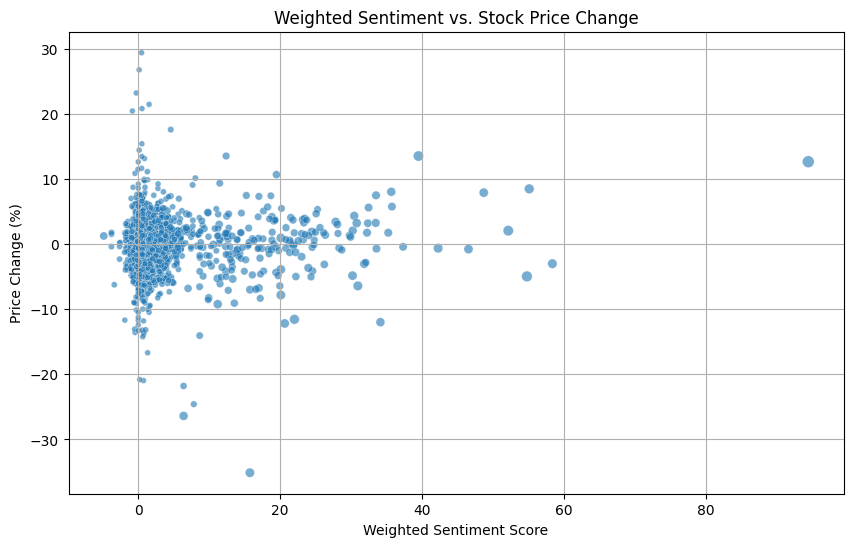

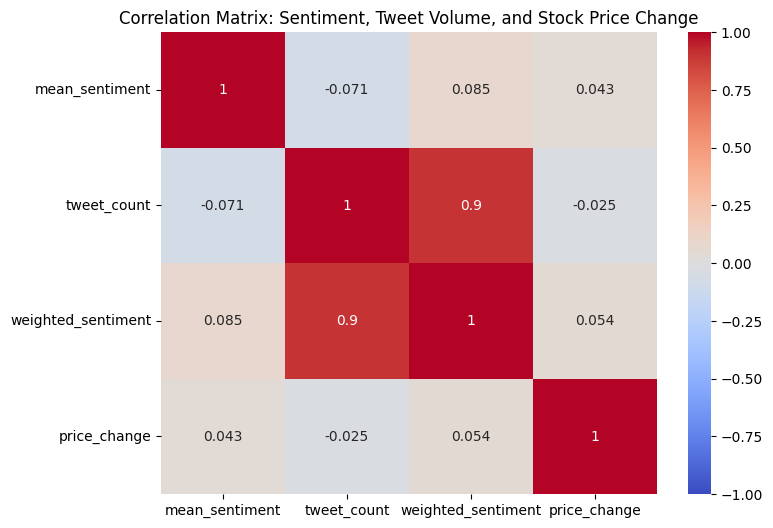

In [459]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weighted_sentiment', y='price_change', size='tweet_count', data=daily_sentiment_stock_data, legend=False, alpha=0.6)
plt.title('Weighted Sentiment vs. Stock Price Change')
plt.xlabel('Weighted Sentiment Score')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()

# Correlation matrix
correlation_matrix = daily_sentiment_stock_data[['mean_sentiment', 'tweet_count', 'weighted_sentiment', 'price_change']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix: Sentiment, Tweet Volume, and Stock Price Change')
plt.show()


As we can see, there is some correlation between the sentiment and price change. We cannot say it for sure though. Let's investigate also only days with high volume of trades and most talked about stocks, since we want a lot of data for the certain stock, in order to be able to correlate it. Let's assume if a stock has more than 150 days of tweets, it is a highly talked one and we also get the top 20% of most tweeted days.

In [460]:
stock_day_counts = tweet_data_tidy.groupby('ticker')['date'].nunique()

tickets_with_lots_of_tweets = stock_day_counts[stock_day_counts > 150].index

filtered_tweet_data = tweet_data_tidy[tweet_data_tidy['ticker'].isin(tickets_with_lots_of_tweets)]

# Recalculate daily sentiment for these tickers
filtered_tweet_data.loc[:, 'date'] = pd.to_datetime(filtered_tweet_data['date']).dt.date
daily_sentiment_lots_tweets = filtered_tweet_data.groupby(['date', 'ticker']).agg(
    mean_sentiment=('sentiment', 'mean'),
    tweet_count=('sentiment', 'size')
).reset_index()

Now lets get the top 20% of the days with most tweets, since that might affect the data. The more tweets -> more chance of it changing the stock price. Afterwards we will calculated the price change from the previous date and then display some charts.

In [461]:
daily_sentiment_lots_tweets.date = pd.to_datetime(daily_sentiment_lots_tweets.date)

daily_sentiment_lots_tweets['weighted_sentiment'] = daily_sentiment_lots_tweets['mean_sentiment'] * daily_sentiment_lots_tweets['tweet_count']

# Define a threshold for high activity
activity_threshold = daily_sentiment_lots_tweets['tweet_count'].quantile(0.80) #Top 20% of days by tweet count

high_activity_days = daily_sentiment_lots_tweets[daily_sentiment_lots_tweets['tweet_count'] > activity_threshold]

merged_high_activity_data = pd.merge(high_activity_days, stock_data_tidy, on=['date', 'ticker'])

# Create a copy of stock data
stock_data_copy = stock_data_tidy[['ticker', 'date', 'close']].copy()
stock_data_copy = stock_data_copy.sort_values(by=['ticker', 'date'])

# Create a shifted version of the copied stock data with the previous day's closing prices
stock_data_copy['prev_close'] = stock_data_copy.groupby('ticker')['close'].shift(1)

# Drop prev close in merged_high_activiti_data
if 'prev_close' in merged_high_activity_data.columns:
    merged_high_activity_data = merged_high_activity_data.drop(columns=['prev_close'])

merged_high_activity_data = pd.merge(
    merged_high_activity_data, 
    stock_data_copy[['ticker', 'date', 'prev_close']], 
    on=['ticker', 'date'], 
    how='left'
)

# Calculate the percentage change from the previous day's close
merged_high_activity_data['price_change'] = (
    (merged_high_activity_data['close'] - merged_high_activity_data['prev_close']) / merged_high_activity_data['prev_close']
) * 100

In [462]:
merged_high_activity_data[merged_high_activity_data.price_change < -20]

,date,ticker,mean_sentiment,tweet_count,weighted_sentiment,open,high,low,close,volume,dividends,stock_splits,prev_close,price_change
141,2022-01-21,NFLX,0.101379,63,6.3869,400.429993,409.149994,379.989990,397.500000,58904300.0,NaN,NaN,508.250000,-21.790457
182,2022-02-02,PYPL,0.195837,40,7.8335,139.889999,139.899994,129.009995,132.570007,136264000.0,NaN,NaN,175.800003,-24.590441
187,2022-02-03,META,0.032128,199,6.3934,244.649994,248.000000,235.750000,237.759995,188119900.0,NaN,NaN,323.000000,-26.390095
294,2022-04-20,NFLX,0.069051,228,15.7437,245.199997,248.699997,212.509995,226.190002,133387500.0,NaN,NaN,348.609985,-35.116603


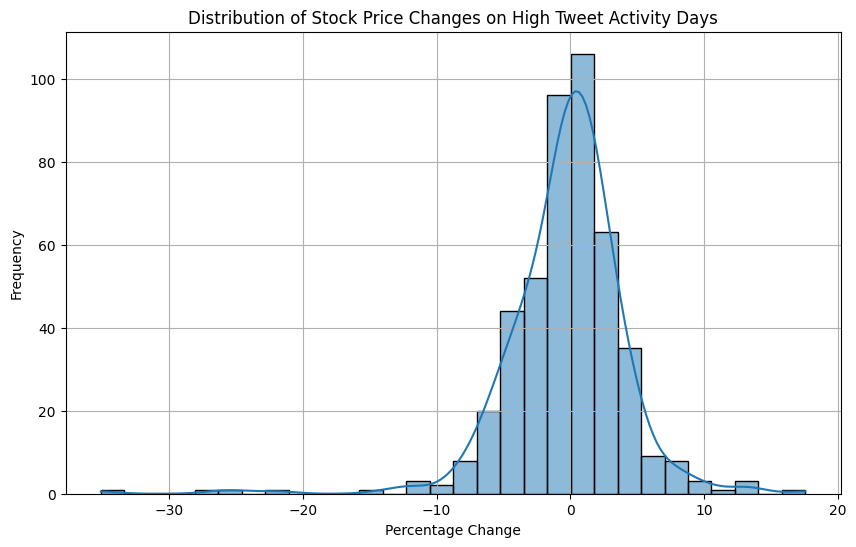

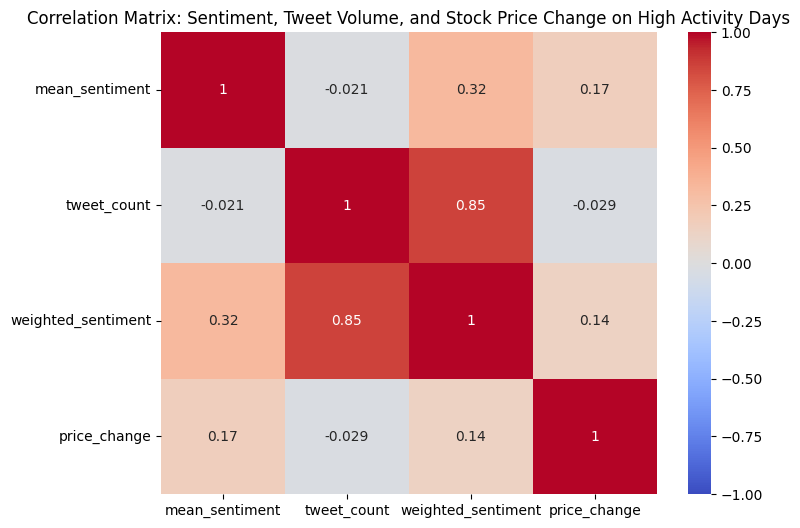

In [463]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_high_activity_data['price_change'], bins=30, kde=True)
plt.title('Distribution of Stock Price Changes on High Tweet Activity Days')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

correlation_matrix_high_activity = merged_high_activity_data[['mean_sentiment', 'tweet_count', 'weighted_sentiment', 'price_change']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_high_activity, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix: Sentiment, Tweet Volume, and Stock Price Change on High Activity Days')
plt.show()

We can obviously see, that there is a correlation between dates with high volume of tweets with sentiment and the stock price. There might for sure be other factors, like earning reports on these days or other stuff, that happens with the company, but this is currently out of scope. We managed to find a correlation and it is not important from what it is.

In some of the more obvious cases, like META on 2022-02-03, they had an earning report that day and this most likely made the people tweet about it and affected the price. So yes, when we have more tweets, something is happening with the stock.

## 6. Conclusion and Recommendations
- **Summary**: Summarize key findings from the analyses.
- **Implications**: Practical implications for investors and financial analysts.
- **Future Research**: Recommendations for future research.

# Bibliography

1. https://www.investopedia.com/terms/s/stockmarket.asp
2. https://www.investopedia.com/articles/basics/04/100804.asp